<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : MohammadAli Olama
### Student Number : 98100497
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [5]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.1307, std=0.3081),
])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [6]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [7]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
num_threads = 2     
batch_size  = 16  


train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_threads)

val_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_threads)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [8]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

from torch.nn import *

def conv3x3(in_planes, out_planes):
    return Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1)


class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.block1 = Sequential(
            conv3x3(1 , 16),
            ReLU(inplace = True),
            MaxPool2d(2, 2)
        )

        self.block2 = Sequential(
            conv3x3(16 , 16),
            ReLU(inplace = True),
            conv3x3(16 , 16),
            ReLU(inplace = True)
        )

        self.block3 = Sequential(
            MaxPool2d(2, 2),
            conv3x3(16 , 64),
            ReLU(inplace = True)
        )

        self.block4 = Sequential(
              conv3x3(64,64),
              ReLU(inplace = True),
              conv3x3(64,64),
              ReLU(inplace = True)
        )
        
        self.block5 = Sequential(
            AdaptiveAvgPool2d(1),
            Flatten(),
            Linear(64, 10)
        )


    def forward(self, x):
        res1 = self.block1(x)
        res1_clone = torch.clone(res1)
        res1 = res1 + self.block2(res1_clone)
        res2 = self.block3(res1)
        res2 = res2 + self.block4(torch.clone(res2))
        res3 = self.block5(res2)  
        return res3

# Train Model (30 Points)

In [9]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
from torch import optim

model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [10]:
def update_confusion_matrix(conf_matrix, preds, reals):
    for i in range(len(preds)):
        t = preds[i]
        s = reals[i]
        conf_matrix[t][s] +=1
        
    return conf_matrix


def f1_score(confusion_matrix):
    epsilon = 1e-7
    row_sum = np.sum(confusion_matrix , axis=1)
    per_class_precision_matrix = confusion_matrix.diagonal() / (row_sum + epsilon)
    
    col_sum = np.sum(confusion_matrix , axis=0)
    
    per_class_recall_matrix = confusion_matrix.diagonal() / (col_sum + epsilon)
    
    per_class_f1_score = (2*per_class_precision_matrix*per_class_recall_matrix) / (per_class_recall_matrix + per_class_precision_matrix + epsilon)
    f1_scor = np.mean(per_class_f1_score)
    
    return f1_scor # , per_class_precision_matrix , per_class_recall_matrix , per_class_f1_score



In [11]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20

train_loss = []
val_loss = []
train_f1 = []
val_f1 = []
train_acc = []
val_acc = []


for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        confusion = np.zeros((10, 10))
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            N += labels.shape[0]

            tot_loss += criterion(outputs, labels)

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == labels).sum().item()
            confusion = update_confusion_matrix(confusion , predicted_targets.cpu().detach().numpy(), labels.cpu().detach().numpy())
        f1 = f1_score(confusion)
        val_loss.append(tot_loss.cpu().detach().numpy()/N)
        val_acc.append(correct/N)
        val_f1.append(f1)
        print("Epoch {:d} -  Validation : Loss : {:.4f}, Acc : {:.4f}, f1 : {:.4f}".format(epoch , tot_loss/N, correct/N , f1))


Epoch 0 -  Validation : Loss : 0.0193, Acc : 0.9039, f1 : 0.9034
Epoch 1 -  Validation : Loss : 0.0094, Acc : 0.9541, f1 : 0.9545
Epoch 2 -  Validation : Loss : 0.0112, Acc : 0.9464, f1 : 0.9461
Epoch 3 -  Validation : Loss : 0.0135, Acc : 0.9395, f1 : 0.9401
Epoch 4 -  Validation : Loss : 0.0083, Acc : 0.9573, f1 : 0.9572
Epoch 5 -  Validation : Loss : 0.0110, Acc : 0.9428, f1 : 0.9427
Epoch 6 -  Validation : Loss : 0.0120, Acc : 0.9459, f1 : 0.9456
Epoch 7 -  Validation : Loss : 0.0072, Acc : 0.9648, f1 : 0.9646
Epoch 8 -  Validation : Loss : 0.0095, Acc : 0.9552, f1 : 0.9550
Epoch 9 -  Validation : Loss : 0.0090, Acc : 0.9572, f1 : 0.9570
Epoch 10 -  Validation : Loss : 0.0080, Acc : 0.9619, f1 : 0.9618
Epoch 11 -  Validation : Loss : 0.0088, Acc : 0.9576, f1 : 0.9577
Epoch 12 -  Validation : Loss : 0.0071, Acc : 0.9672, f1 : 0.9671
Epoch 13 -  Validation : Loss : 0.0069, Acc : 0.9675, f1 : 0.9674
Epoch 14 -  Validation : Loss : 0.0105, Acc : 0.9542, f1 : 0.9539
Epoch 15 -  Validati

In [12]:
tot_loss
val_loss

[0.019265640258789064,
 0.009362491607666015,
 0.01122547378540039,
 0.013463914489746093,
 0.008299237060546876,
 0.010987458801269532,
 0.011969559478759766,
 0.007241419982910156,
 0.009546926879882813,
 0.008999069976806641,
 0.008016445922851563,
 0.008813347625732422,
 0.007052747344970703,
 0.006923649597167968,
 0.010498679351806641,
 0.007369308471679687,
 0.006667023468017578,
 0.009775468444824218,
 0.008370712280273437,
 0.007330635833740234]

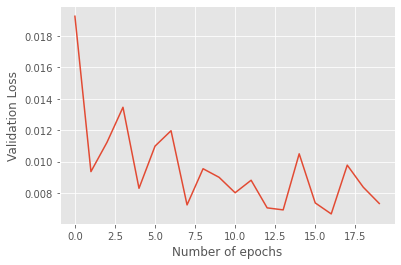

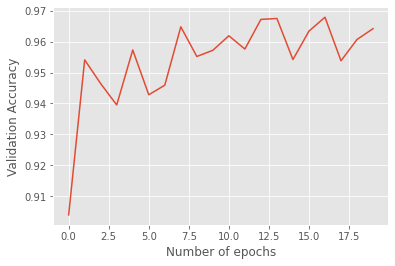

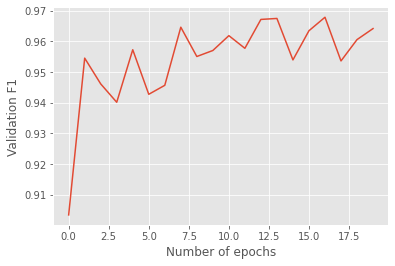

In [13]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure()
# ax = plt.scatter(x=list(range(num_epochs)), y=range(num_epochs))
# plt.xlabel("Number of epochs")
# plt.ylabel("Validation Loss")
# plt.show()

plt.figure()
ax = sns.lineplot(x=list(range(num_epochs)), y=list(val_loss))
plt.xlabel("Number of epochs")
plt.ylabel("Validation Loss")
plt.show()


plt.figure()
ax = sns.lineplot(x=list(range(num_epochs)), y=list(val_acc))
plt.xlabel("Number of epochs")
plt.ylabel("Validation Accuracy")
plt.show()

plt.figure()
ax = sns.lineplot(x=list(range(num_epochs)), y=list(val_f1))
plt.xlabel("Number of epochs")
plt.ylabel("Validation F1")
plt.show()

# Test Model (20 Points)

In [14]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))


with torch.no_grad():
    model.eval()
    N = 0
    tot_loss, correct = 0.0, 0.0
    confusion = np.zeros((10, 10))
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        N += labels.shape[0]

        tot_loss += criterion(outputs, labels)

        predicted_targets = outputs.argmax(dim=1)
        correct += (predicted_targets == labels).sum().item()
        confusion = update_confusion_matrix(confusion , predicted_targets.cpu().detach().numpy(), labels.cpu().detach().numpy())
    f1 = f1_score(confusion)
    val_loss.append(tot_loss/N)
    val_acc.append(correct/N)
    val_f1.append(f1)
    print("Test : Loss : {:.4f}, Acc : {:.4f}, f1 : {:.4f}".format( tot_loss/N, correct/N , f1))


10000
Test : Loss : 0.0017, Acc : 0.9668, f1 : 0.9666


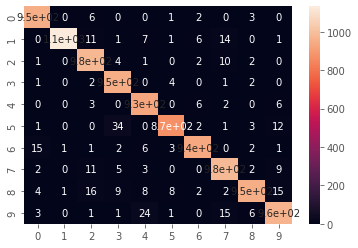

In [15]:
import seaborn as sn
sn.heatmap(confusion, annot=True)